In [1]:
import calendar
import json
import os
import time
import traceback
from datetime import datetime

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import requests
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T

spark = (
    SparkSession.builder
        .master("local")
        .appName("TFL Notebook")
        .getOrCreate()
)

trips = spark.read.parquet("data/parquet_trip")

trips.limit(10).toPandas()


,rental_id,duration,bike_id,end_station_id,end_station_name,start_station_id,start_station_name,start_ts,start_year,start_month,start_day,start_day_of_week,start_hour,end_ts,end_year,end_month,end_day,end_day_of_week,end_hour
0,61460085,660,139,819,"Belvedere Road 2, South Bank",217,"Wormwood Street, Liverpool Street",2017-01-05 07:04:00,2017,1,5,5,7,2017-01-05 07:15:00,2017,1,5,5,7
1,61449020,660,6359,217,"Wormwood Street, Liverpool Street",819,"Belvedere Road 2, South Bank",2017-01-04 16:05:00,2017,1,4,4,16,2017-01-04 16:16:00,2017,1,4,4,16
2,61437158,600,14302,819,"Belvedere Road 2, South Bank",217,"Wormwood Street, Liverpool Street",2017-01-04 07:17:00,2017,1,4,4,7,2017-01-04 07:27:00,2017,1,4,4,7
3,61473622,660,8877,217,"Wormwood Street, Liverpool Street",273,"Belvedere Road 1, South Bank",2017-01-05 16:02:00,2017,1,5,5,16,2017-01-05 16:13:00,2017,1,5,5,16
4,61484961,600,5700,819,"Belvedere Road 2, South Bank",217,"Wormwood Street, Liverpool Street",2017-01-06 07:16:00,2017,1,6,6,7,2017-01-06 07:26:00,2017,1,6,6,7
5,61482672,420,13720,246,"Berry Street, Clerkenwell",433,"Wren Street, Holborn",2017-01-05 21:05:00,2017,1,5,5,21,2017-01-05 21:12:00,2017,1,5,5,21
6,61482473,420,13720,433,"Wren Street, Holborn",594,"Kingsway Southbound, Strand",2017-01-05 20:45:00,2017,1,5,5,20,2017-01-05 20:52:00,2017,1,5,5,20
7,61470321,480,12610,162,"Southampton Place, Holborn",246,"Berry Street, Clerkenwell",2017-01-05 13:00:00,2017,1,5,5,13,2017-01-05 13:08:00,2017,1,5,5,13
8,61447445,540,11477,358,"High Holborn , Covent Garden",246,"Berry Street, Clerkenwell",2017-01-04 14:22:00,2017,1,4,4,14,2017-01-04 14:31:00,2017,1,4,4,14
9,61495906,360,10616,427,"Cheapside, Bank",66,"Holborn Circus, Holborn",2017-01-06 14:01:00,2017,1,6,6,14,2017-01-06 14:07:00,2017,1,6,6,14


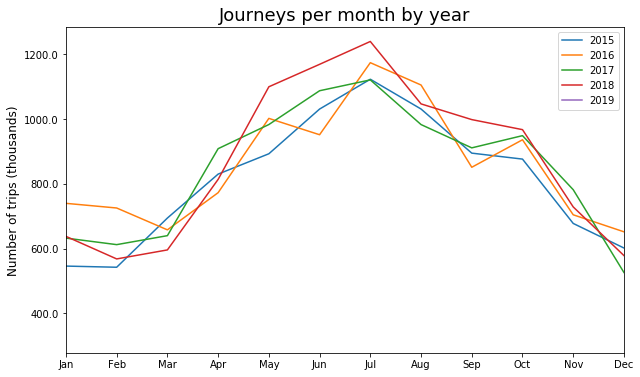

In [2]:
df = (
    trips
    .groupby('start_year', 'start_month')
    .agg({
        "*": "count",
        "duration": "avg",
    })
    .toPandas()
    .sort_values(['start_year', 'start_month'], ascending=[True, True])
)

fig, ax = plt.subplots(figsize=(10, 6))
plt.xticks(range(0,13), calendar.month_abbr)

ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x)/1000)))

for key, grp in df.groupby(['start_year']):
    ax = grp.plot(ax=ax, kind='line', x='start_month', y='count(1)', label=key)

plt.title("Journeys per month by year", fontsize=18)
plt.xlabel('')
plt.ylabel('Number of trips (thousands)', fontsize=12)
plt.legend(loc='best')

plt.show()